## 3D Visualization of cooling Kob-Andersen Lennard-Jones mixture
Requires the 'k3d' and  'ipywidgets' packages

In [1]:
import numpy as np
import rumdpy as rp
import numba

import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget


## Generate configuration with a FCC lattice

In [2]:
c1 = rp.make_configuration_fcc(nx=6, ny=6, nz=6, rho=0.60, T=3.44) 
c1.ptype[::5] = 1 # 4:1 mixture

print(f'Number of particles: {c1.N}; Density: {c1.N/np.prod(c1.simbox.lengths):.3f}; B fraction: {np.mean(c1.ptype==1):.3f}')

Number of particles: 864; Density: 0.600; B fraction: 0.200


## Setup Lennard-Jones pair potential

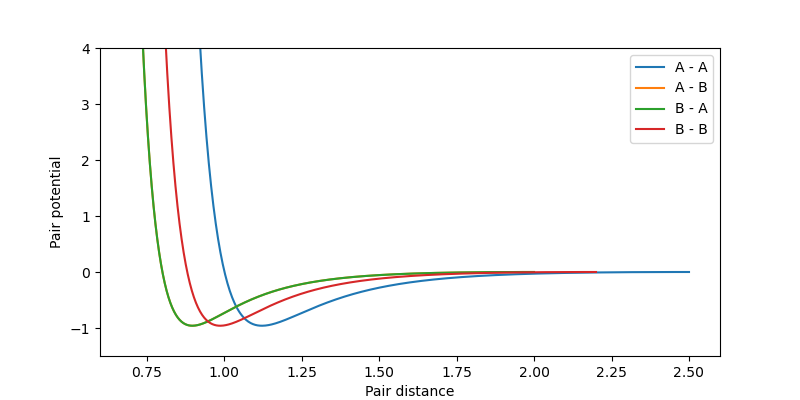

In [3]:
pairfunc = rp.apply_shifted_force_cutoff(rp.LJ_12_6_sigma_epsilon)
sig = [[1.00, 0.80],
       [0.80, 0.88]]
eps = [[1.00, 1.50],
       [1.50, 0.50]]
cut = np.array(sig)*2.5
pairpot = rp.PairPotential2(pairfunc, params=[sig, eps, cut], max_num_nbs=1000)
pairpot.plot(names=['A', 'B'], xlim=(0.6, 2.6), ylim=(-1.5, 4))

## Setup integrator

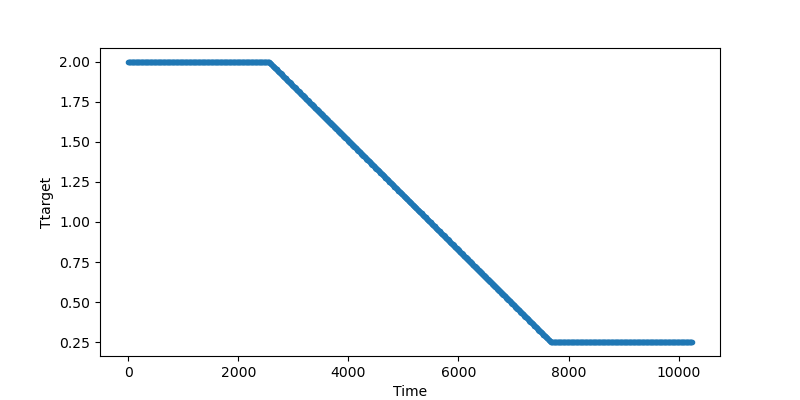

In [4]:
dt = 0.005                # Duration of timestep 
num_blocks = 1000         # Do simulation in this many 'blocks'
steps_per_block = 2*1024  # ... each of this many timesteps
running_time = dt*num_blocks*steps_per_block

Ttarget_function = rp.make_function_ramp(value0=2.00, x0=running_time*(1/4), 
                                         value1=0.25, x1=running_time*(3/4))
integrator = rp.integrators.NVT(Ttarget_function, tau=0.2, dt=dt)

plt.figure(figsize=(8,4))
t = np.linspace(0,running_time,num_blocks)
plt.plot(t, numba.vectorize(Ttarget_function)(t), '.-')
plt.xlabel('Time')
plt.ylabel('Ttarget')
plt.show()

## Setup simulation

In [5]:
sim = rp.Simulation(c1, pairpot, integrator,
                    num_timeblocks=num_blocks, steps_per_timeblock=steps_per_block,
                    storage='memory')

Storing results in memory. Expected footprint  257.08 MB.


## Run simulation with 3D visualization

In [6]:
from rumdpy.visualization import k3d_Visualization

viz = k3d_Visualization(sim)
viz.display()
for block in sim.timeblocks():
    viz.update(block, choice=0)
viz.display_player()
print('\n', sim.summary())

Output()


 particles : 864 
steps : 2048000 
nbflag : [     0      0 154233] 
time : 41.64 s 
TPS : 4.92e+04
